In [2]:
import os
import pickle
import time
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from types import SimpleNamespace
from collections import defaultdict
from numba import jit

# utils imports
from power_planner.data_reader import DataReader
from power_planner import graphs
from power_planner.plotting import plot_path_costs, plot_pipeline_paths, plot_path, plot_k_sp
from power_planner.utils.utils import get_distance_surface, time_test_csv, compute_pylon_dists
from power_planner.utils.utils_ksp import KspUtils

In [3]:
PATH_FILES = "../data"

# DEFINE CONFIGURATION
ID = "w_ksp_5"  # str(round(time.time() / 60))[-5:]

OUT_PATH = "outputs/path_" + ID
SCALE_PARAM = 5  # args.scale
# normal graph pipeline
# PIPELINE = [(2, 50), (1, 0)]  # [(1, 0)]  # [(4, 80), (2, 50), (1, 0)]  #
# random graph pipeline
PIPELINE = [(1, 0)]  # [(0.9, 40), (0, 0)]

GRAPH_TYPE = graphs.ImplicitKSP
# LineGraph, WeightedGraph, RandomWeightedGraph, RandomLineGraph, PowerBF
# TwoPowerBF, WeightedKSP
print("graph type:", GRAPH_TYPE)
# summarize: mean/max/min, remove: all/surrounding, sample: simple/watershed
NOTES = "None"  # "mean-all-simple"

IOPATH = os.path.join(PATH_FILES, "belgium_dump_" + str(SCALE_PARAM) + ".dat")

with open("../config.json", "r") as infile:
    cfg_dict = json.load(infile)  # Config(SCALE_PARAM)
    cfg = SimpleNamespace(**cfg_dict)
    cfg.PYLON_DIST_MIN, cfg.PYLON_DIST_MAX = compute_pylon_dists(
        cfg.PYLON_DIST_MIN, cfg.PYLON_DIST_MAX, cfg.RASTER, SCALE_PARAM
    )
    
# READ DATA
with open(IOPATH, "rb") as infile:
    data = pickle.load(infile)
    (instance, instance_corr, start_inds, dest_inds) = data.data
    
tic1 = time.time()
graph = GRAPH_TYPE(
    instance, instance_corr, graphtool=cfg.GTNX, verbose=cfg.VERBOSE
)

graph.set_shift(
    cfg.PYLON_DIST_MIN,
    cfg.PYLON_DIST_MAX,
    dest_inds - start_inds,
    cfg.MAX_ANGLE,
    max_angle_lg=cfg.MAX_ANGLE_LG
)
corridor = np.ones(instance_corr.shape) * 0.5  # start with all

graph.set_corridor(corridor, start_inds, dest_inds, factor_or_n_edges=1)

graph.set_edge_costs(
    data.layer_classes, data.class_weights, angle_weight= 0.1 # cfg.ANGLE_WEIGHT
)
# add vertices
graph.add_nodes()

# START PIPELINE
tic = time.time()
print("1) set cost rest")
graph.add_edges(edge_weight=0) # .2)
print("2) added edges", graph.n_edges)
print("number of vertices:", graph.n_nodes)

# weighted sum of all costs
graph.sum_costs()
source_v, target_v = graph.add_start_and_dest(start_inds, dest_inds)
print("3) summed cost, get source and dest")
# get actual best path
path, path_costs, cost_sum = graph.get_shortest_path(source_v, target_v)
print("4) shortest path")
print(time.time()-tic1)

graph.get_shortest_path_tree(source_v, target_v)

graph type: <class 'power_planner.graphs.impl_ksp.ImplicitKSP'>
defined pylon distances in raster: 3.0 5.0
cost weights [0.09090909 0.3030303  0.22727273 0.15151515 0.22727273]
instance shape (147, 260)
memory taken (dists shape): 1070160
1) set cost rest
time topo sort: 1.137
time edges: 2.76
2) added edges 1070160
number of vertices: 38220
3) summed cost, get source and dest
4) shortest path
5.059413909912109
time shortest_path_tree: 1.192


In [4]:
ksp = graph.k_shortest_paths(start_inds, dest_inds, 5)

/Users/ninawiedemann/Desktop/thesis/power_planner.nosync/power_planner/graphs/impl_ksp.py:163: RuntimeWarning: invalid value encountered in subtract
  summed_dists = (self.dists + self.dists_ba - self.instance)


1553


In [5]:
def compute_min_node_dists(self):
    best_paths = [self.best_path]
    tuple_path = [tuple(p) for p in self.best_path]
    sp_set = set(tuple_path)
    # sum both dists_ab and dists_ba, subtract inst because counted twice
    summed_dists = (self.dists + self.dists_ba - self.instance)
    # mins along outgoing edges
    min_node_dists = np.min(summed_dists, axis=0)
    min_shift_dists = np.argmin(summed_dists, axis=0)
    # argsort
    v_shortest = np.argsort(min_node_dists.flatten())
    return min_node_dists, v_shortest, min_shift_dists

In [6]:
min_node_dists, v_shortest, min_shift_dists = compute_min_node_dists(graph)

<ipython-input-5-eab3cb11071e>:6: RuntimeWarning: invalid value encountered in subtract
  summed_dists = (self.dists + self.dists_ba - self.instance)


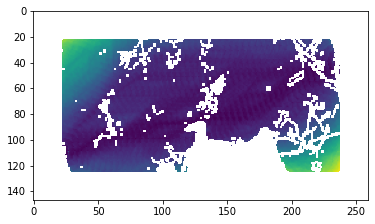

In [7]:
plt.imshow(min_node_dists)

In [128]:
def currently_implemented(self, source, dest, k, overlap=0.5):
    tic = time.time()
    ksp = self.k_shortest_paths(source, dest, k, overlap=overlap)
    toc = time.time()
    return ksp, toc-tic

In [127]:
def eucl_max(self, source, dest, k, overlap=8):
    tic = time.time()
    min_node_dists, v_shortest, min_shift_dists = compute_min_node_dists(self)  
    best_paths = [self.best_path]
    tup_path = [np.array(p) for p in self.best_path]
    # sp_set = set(tuple_path)
    sorted_dists = min_node_dists.flatten()[v_shortest]
    _, arr_len  = min_node_dists.shape

    expanded = 0
    for j in range(len(v_shortest)):
        if sorted_dists[j]==sorted_dists[j-1]:
            # we always check a path only if it is the x-th appearance
            # print(counter)
            continue
         
        # counter large enough --> expand
        (x2, x3) = v_shortest[j]//arr_len, v_shortest[j]%arr_len
        
        # compute eucledian distances
        eucl_dist = [np.linalg.norm(np.array([x2,x3]) - tup) for tup in tup_path]
        if np.min(eucl_dist)>overlap:
            expanded += 1
            x1 = min_shift_dists[x2,x3]
            if self.dists_ba[x1, x2, x3] == 0:
                # print("inc edge to dest")
                # = 0 for inc edges of dest_inds (init of dists_ba)
                continue
            vertices_path = self._combined_paths(
                source, dest, x1, [x2, x3]
            )
            # assert np.any([np.array([x2,x3])==v for v in vertices_path])
            best_paths.append(vertices_path)
            for v in vertices_path:
                v_in = [np.all(v==elem) for elem in tup_path]
                if not np.any(v_in):
                    tup_path.append(v)

            if len(best_paths) >= k:
                print(j, "expanded", expanded)
                break
    toc = time.time()
    ksp = [self.transform_path(path) for path in best_paths]
    return ksp, toc-tic

In [126]:
def set_max_cost(self, cost_thresh):
    # set maximum on costs
    best_path_cells, _, best_cost = self.transform_path(self.best_path)
    correction = 0.5 * (
        self.instance[tuple(best_path_cells[0])] +
        self.instance[tuple(best_path_cells[-1])]
    )
    print(best_cost, max_cost * best_c)
    assert np.isclose(best_cost, cost_thresh + correction)
    max_costs = best_cost * cost_thresh - correction
    return max_costs
    
    max_costs = best_cost * cost_thresh - correction

def most_diverse(self, source, dest, k, cost_thresh, dist_mode="jaccard"):
    tic = time.time()
    min_node_dists, v_shortest, min_shift_dists = compute_min_node_dists(self)
    sorted_dists = min_node_dists.flatten()[v_shortest]
    best_path_cells, _, best_cost = self.transform_path(self.best_path)
    max_cost = best_cost * cost_thresh # set_max_cost(self, sorted_dists[0])
    _, arr_len = min_node_dists.shape
    collected_path = []
    for j in range(len(v_shortest)):
        if sorted_dists[j]==sorted_dists[j-1]:
            continue
            
        if sorted_dists[j] > max_cost:
            break
            
         # counter large enough --> expand
        (x2, x3) = v_shortest[j]//arr_len, v_shortest[j]%arr_len
        x1 = min_shift_dists[x2,x3]
        if self.dists_ba[x1, x2, x3] == 0:
            # print("inc edge to dest")
            # = 0 for inc edges of dest_inds (init of dists_ba)
            continue
        vertices_path = self._combined_paths(
            source, dest, x1, [x2, x3]
        )
        collected_path.append(vertices_path)
        
    dists = KspUtils.pairwise_dists(collected_path, mode=dist_mode)
    
    # find the two which are most diverse (following 2-approx)
    max_dist_pair = np.argmax(dists)
    div_ksp = [max_dist_pair // len(dists), max_dist_pair % len(dists)]
    # greedily add the others
    for _ in range(k - 2):
        min_dists = []
        for i in range(len(dists)):
            min_dists.append(np.min([dists[i, div_ksp]]))
        div_ksp.append(np.argmax(min_dists))
    
    ksp = [self.transform_path(collected_path[p]) for p in div_ksp]
    print(len(collected_path))
    toc = time.time()
    return ksp, toc-tic

def most_diverse_jaccard(self, source, dest, k, cost_thresh):
    return most_diverse(self, source, dest, k, cost_thresh, dist_mode="jaccard")
def most_diverse_eucl_max(self, source, dest, k, cost_thresh):
    return most_diverse(self, source, dest, k, cost_thresh, dist_mode="eucl_max")

In [7]:
def laplace(self, source, dest, k, radius = 20, cost_add=0.05):
    tic = time.time()
    best_paths = [self.best_path]
    min_node_dists, v_shortest, min_shift_dists = compute_min_node_dists(self)
    # print(min_node_dists)
    best_path_cells, _, best_cost = self.transform_path(self.best_path)
    factor = best_cost * cost_add
    print(factor)
    _, arr_len = min_node_dists.shape
    for _ in range(k-1):
        # set the already used vertices to inf (not use anymore for selected vertex)
        for b in best_paths[-1]:
            min_node_dists[tuple(b)] = np.inf
        # add in corridor / distribution
        corridor = get_distance_surface(
                min_node_dists.shape,
                best_paths,
                mode="dilation",
                n_dilate=radius
            )
        corridor = corridor / np.max(corridor)
        min_node_dists = min_node_dists + corridor * factor
        # get min vertex
        current_best = np.nanargmin(min_node_dists.flatten())
        (x2, x3) = current_best//arr_len, current_best%arr_len
        # print(x2, x3, arr_len, current_best)
        x1 = min_shift_dists[x2,x3]
        if self.dists_ba[x1, x2, x3] == 0:
            k+=1
            continue
        # compute and add
        vertices_path = self._combined_paths(
            source, dest, x1, [x2, x3]
        )
        best_paths.append(vertices_path)
    # output
    ksp = [self.transform_path(p) for p in best_paths]
    toc = time.time()
    return ksp, toc-tic

ksp, toc = laplace(graph, start_inds, dest_inds, 5, radius=10, cost_add=0.005)

0.0590618596378187


<ipython-input-5-eab3cb11071e>:6: RuntimeWarning: invalid value encountered in subtract
  summed_dists = (self.dists + self.dists_ba - self.instance)


In [ ]:
ksp, tic = most_diverse(graph, start_inds, dest_inds, 5, 1.01)
print(tic)

## Evaluate algorithms

In [87]:
from collections import defaultdict

#### Collect all results

In [174]:
res_dict = defaultdict(list)
metrics = ["eucl_mean", "eucl_max", "jaccard"]

func_eval = [eucl_max, eucl_max, eucl_max, eucl_max, 
             currently_implemented,currently_implemented,currently_implemented,currently_implemented, 
             most_diverse_jaccard, most_diverse_jaccard, most_diverse_eucl_max, most_diverse_eucl_max, 
             laplace, laplace, laplace, laplace]
names = ["vertex eucl max", "vertex eucl max", "vertex eucl max","vertex eucl max", 
         "greedy max set", "greedy max set", "greedy max set", "greedy max set",
         "diverse jaccard", "diverse jaccard", "diverse eucl max", "diverse eucl max",
         "corridor", "corridor", "corridor", "corridor"]
thresh_eval = [6, 8, 12, 14, 
               0.4, 0.6, 0.8, 1.0,
               1.01, 1.05, 1.01, 1.05,
               7, 10, 15, 20]
assert len(func_eval)==len(names)
assert len(names)==len(thresh_eval)

all_ksps = []
for name, func, param in zip(names, func_eval, thresh_eval):
    ksp, tic = func(graph, start_inds, dest_inds, 5, param)
    all_ksps.append(ksp)
    res_dict["name"].append(name)
    res_dict["threshold"].append(param)
    res_dict["times"].append(tic)
    for m in metrics:
        res_dict[m+"_distance"].append(evaluate_sim(ksp, m))
    cost_sum, cost_max = evaluate_cost(ksp)
    res_dict["cost_sum"].append(cost_sum)
    res_dict["cost_max"].append(cost_max)

<ipython-input-5-eab3cb11071e>:6: RuntimeWarning: invalid value encountered in subtract
  summed_dists = (self.dists + self.dists_ba - self.instance)


0.7133919112058562
0.7133919112058562
0.7133919112058562
0.7133919112058562


In [165]:
res_dict["name"]

['vertex eucl max',
 'vertex eucl max',
 'vertex eucl max',
 'vertex eucl max',
 'greedy max set',
 'greedy max set',
 'greedy max set',
 'greedy max set',
 'diverse jaccard',
 'diverse jaccard',
 'diverse eucl max']

#### Add another one

In [181]:
name = "corridor01"
param = 5

# for name, func, param in zip(names, func_eval, thresh_eval):
ksp, tic = laplace(graph, start_inds, dest_inds, 5, param, cost_add=0.01)
all_ksps.append(ksp)
res_dict["name"].append(name)
res_dict["threshold"].append(param)
res_dict["times"].append(tic)
for m in metrics:
    res_dict[m+"_distance"].append(evaluate_sim(ksp, m))
cost_sum, cost_max = evaluate_cost(ksp)
res_dict["cost_sum"].append(cost_sum)
res_dict["cost_max"].append(cost_max)

0.14267838224117121


<ipython-input-5-eab3cb11071e>:6: RuntimeWarning: invalid value encountered in subtract
  summed_dists = (self.dists + self.dists_ba - self.instance)


#### Create table

In [183]:
df_ksp_compare = pd.DataFrame(res_dict, index=res_dict["name"])
df_ksp_compare["extended_names"] = [n+"_"+str(int(t)) for n, t in zip(res_dict["name"], res_dict["threshold"])]
np.around(df_ksp_compare, 3)

,name,threshold,times,eucl_mean_distance,eucl_max_distance,jaccard_distance,cost_sum,cost_max,extended_names
vertex eucl max,vertex eucl max,6.00,0.355,1.289,9.351,0.410,71.597,14.383,vertex eucl max_6
vertex eucl max,vertex eucl max,8.00,0.562,1.819,10.939,0.468,71.714,14.421,vertex eucl max_8
vertex eucl max,vertex eucl max,12.00,1.029,4.830,17.582,0.655,72.018,14.470,vertex eucl max_12
vertex eucl max,vertex eucl max,14.00,2.497,5.554,20.731,0.664,72.169,14.534,vertex eucl max_14
greedy max set,greedy max set,0.40,1.474,4.497,14.428,0.853,72.091,14.513,greedy max set_0
greedy max set,greedy max set,0.60,0.402,1.988,9.422,0.711,71.759,14.392,greedy max set_0
greedy max set,greedy max set,0.80,0.267,1.234,6.799,0.587,71.570,14.364,greedy max set_0
greedy max set,greedy max set,1.00,0.093,0.658,6.723,0.313,71.362,14.277,greedy max set_1
diverse jaccard,diverse jaccard,1.01,7.133,1.557,6.387,0.724,71.709,14.365,diverse jaccard_1
diverse jaccard,diverse jaccard,1.05,6887.247,14.490,33.793,0.943,73.752,14.860,diverse jaccard_1


#### Save

In [185]:
df_ksp_compare.to_csv("compare_diverse_ksp.csv")

#### Plot pareto

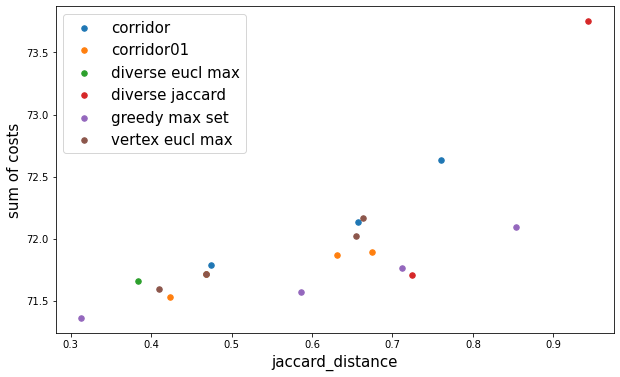

In [240]:
plt.figure(figsize=(10,6))
chosen_metric = "jaccard_distance"
for name, grouped in df_ksp_compare.groupby("name"):
    plt.scatter(grouped[chosen_metric], grouped["cost_sum"], label = name, s=30)
plt.legend(fontsize=15)
plt.xlabel(chosen_metric, fontsize=15)
plt.ylabel("sum of costs", fontsize=15)
plt.show()

In [205]:
take_names = ["greedy max set_1", "vertex eucl max_6", "vertex eucl max_8", "corridor01_20", "corridor01_5","diverse eucl max_1"]


In [206]:
test = df_ksp_compare.copy()

In [207]:
take_inds = test["extended_names"].isin(take_names)

In [219]:
test_smaller72 = test[take_inds]

In [220]:
test_smaller72["explanation"] = ["Greedily add the next VERTEX with eucl distance > 300m to all previous paths",
                                "Greedily add the next VERTEX with eucl distance > 500m to all previous paths",
                                "Greedily add the next shortest path with less than x% vertices already used in previous paths",
                                "P-dispersion - find k most diverse paths (Yen-Hausdorff) out of all paths with cost < 1.01 * best path cost",
                                "Add penalty x in distribution fashion to the cost surface in corridor of radius 20 around the previous paths",
                                "Add penalty x in distribution fashion to the cost surface in corridor of radius 5 around the previous paths"
                                ]


<ipython-input-220-a80ec21dedc9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_smaller72["explanation"] = ["Greedily add the next VERTEX with eucl distance > 300m to all previous paths",


In [222]:
final = np.around(test_smaller72[["extended_names", "explanation", "times", "eucl_max_distance", "jaccard_distance", "cost_sum"]], 2)

In [223]:
final.head(10)

,extended_names,explanation,times,eucl_max_distance,jaccard_distance,cost_sum
vertex eucl max,vertex eucl max_6,Greedily add the next VERTEX with eucl distanc...,0.36,9.35,0.41,71.60
vertex eucl max,vertex eucl max_8,Greedily add the next VERTEX with eucl distanc...,0.56,10.94,0.47,71.71
greedy max set,greedy max set_1,Greedily add the next shortest path with less ...,0.09,6.72,0.31,71.36
diverse eucl max,diverse eucl max_1,P-dispersion - find k most diverse paths (Yen-...,217.69,8.12,0.38,71.66
corridor01,corridor01_20,Add penalty x in distribution fashion to the c...,0.16,21.04,0.67,71.89
corridor01,corridor01_5,Add penalty x in distribution fashion to the c...,0.10,9.11,0.42,71.53


In [90]:
def evaluate_sim(ksp, metric):
    """
    evaluate ksp diversity according to several metric
    """
    ksp_paths = [k[0] for k in ksp]
    out_diversity = [] # np.zeros((3,2))
    # for k, metric in enumerate(["eucl_mean", "eucl_max", "jaccard"]):
    divs = []
    for i in range(len(ksp_paths)):
        for j in range(i+1,len(ksp_paths)):
            divs.append(KspUtils.path_distance(ksp_paths[i],ksp_paths[j], mode=metric))
        # out_diversity.append(np.mean(divs))
        # out_diversity[k,1] = np.sum(divs)
    # return out_diversity
    return np.mean(divs)

def evaluate_cost(ksp):
    # ksp_path_costs = [k[1] for k in ksp]
    # for p_cost in ksp_path_costs:
    #     p = np.asarray(p_cost)
    #     c_m = np.mean(np.sum(p,axis=1))
    ksp_all_costs = [k[2] for k in ksp]
    return [np.sum(ksp_all_costs), np.max(ksp_all_costs)]

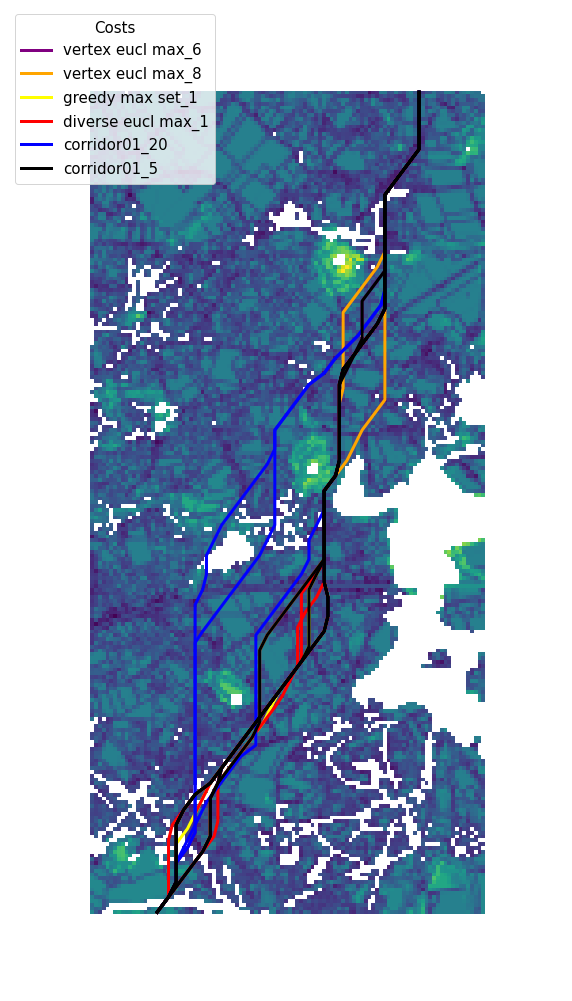

In [238]:
def plot_several_ksp(all_ksp, ksp_names, inst, out_path=None):
    """
    Plot k shortest paths on the instance
    Arguments:
        ksp: list of infos for the k shortest path: for each path, the first
            entry is the path itself, the second the costs array, the third
            the cost sum
        inst: instance to plot on
    """
    cols = ["purple", "orange", "yellow", "red", "blue", "black", "green"][:len(ksp_names)]
    
    # plot main image (cost surface)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.swapaxes(inst, 1, 0))
    
    # get relevant information
    for ksp, names, colour in zip(all_ksp, ksp_names, cols):
        paths = [k[0] for k in ksp]
        # iterate over k shortest paths
        for i, path in enumerate(paths):
            path = np.asarray(path)
            plt.plot(
                path[:, 0], path[:, 1], label=names,c=colour, linewidth=3
            )
    # plot and save
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    leg = plt.legend(by_label.values(), by_label.keys(), fontsize=15)

    leg.set_title('Costs', prop={'size': 15})
    plt.axis("off")
    if out_path is not None:
        plt.savefig(out_path + "_ksp.pdf")
    else:
        plt.show()
        
take_ksps = [all_ksps[i] for i in range(len(all_ksps)) if take_inds.values[i]]
plot_several_ksp(take_ksps, np.asarray(df_ksp_compare["extended_names"])[take_inds], graph.instance)

### Evaluate all together

In [178]:
ksps_set = collect_ksp_results(currently_implemented, [0.4,0.5,0.6, 0.65, 0.7,0.8, 0.9])

/Users/ninawiedemann/Desktop/thesis/power_planner.nosync/power_planner/graphs/impl_ksp.py:184: RuntimeWarning: invalid value encountered in subtract
  summed_dists = (self.dists + self.dists_ba - self.instance)


1812
1499
445
318
258
258
102


In [331]:
ksps_eucl_max.extend(collect_ksp_results(eucl_max, [14, 16, 18]))

<ipython-input-211-eab3cb11071e>:6: RuntimeWarning: invalid value encountered in subtract
  summed_dists = (self.dists + self.dists_ba - self.instance)


2172 expanded 4
4354 expanded 4
5696 expanded 4


In [180]:
ksps_distance = collect_ksp_results(most_diverse_jaccard, [1.005, 1.01, 1.015])

<ipython-input-3-eab3cb11071e>:6: RuntimeWarning: invalid value encountered in subtract
  summed_dists = (self.dists + self.dists_ba - self.instance)


89
303
878


In [380]:
ksps_diverse_eucl = collect_ksp_results(most_diverse_eucl_max, [1.005, 1.01, 1.015])

<ipython-input-211-eab3cb11071e>:6: RuntimeWarning: invalid value encountered in subtract
  summed_dists = (self.dists + self.dists_ba - self.instance)


89
303
878


In [242]:
ksps_distance.append(most_diverse_jaccard(graph, start_inds, dest_inds, K_PATHS, 1.018)[0])

<ipython-input-211-eab3cb11071e>:6: RuntimeWarning: invalid value encountered in subtract
  summed_dists = (self.dists + self.dists_ba - self.instance)


1658


In [364]:
ksp_laplace_new = collect_ksp_results(laplace, [10,15,20,25,30,35,40])

<ipython-input-211-eab3cb11071e>:6: RuntimeWarning: invalid value encountered in subtract
  summed_dists = (self.dists + self.dists_ba - self.instance)


0.7133919112058562
0.7133919112058562
0.7133919112058562
0.7133919112058562
0.7133919112058562
0.7133919112058562
0.7133919112058562


In [320]:
ksp_laplace = collect_ksp_results(laplace, [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01,0.05, 0.075])

<ipython-input-211-eab3cb11071e>:6: RuntimeWarning: invalid value encountered in subtract
  summed_dists = (self.dists + self.dists_ba - self.instance)


0.00014267838224117123
0.0007133919112058562
0.0014267838224117123
0.007133919112058561
0.014267838224117122
0.07133919112058561
0.14267838224117121
0.7133919112058562
1.070087866808784


In [ ]:
collected_ksps = [ksps_set, ksps_eucl_max, ksps_distance, ksp_laplace, ksps_diverse_eucl]
to_compare_names = ["greedy jaccard", "greedy eucl max", "diverse jaccard", "corridor", "diverse eucl max"]

In [ ]:
plt.figure(figsize=(5,5))
for i, out_ksp in enumerate(collected_ksps):
    res = []
    for ksp in out_ksp:
        cost, dist = ksp_evaluate(ksp)
        cost_normed = cost - cost_sum * K_PATHS
        res.append([cost_normed, -dist])
    res = np.array(res)
    plt.plot(res[:,0], res[:,1], label = to_compare_names[i])
plt.title("comparison of ksp algorithms")
plt.xlabel("sum of costs")
plt.ylabel("similarity")
plt.legend()
plt.show()

In [369]:
def ksp_evaluate(ksp):
    # METRIC 1: just sum of all pairwise maximum pylonwise distance 
    costs = [k[2] for k in ksp]
    paths = [k[0] for k in ksp]
    
    inters = []
    for i in range(len(paths)):
        p1 = paths[i]
        for j in range(i+1,len(paths)):
            p2 = paths[j]
            norms = []
            for k in range(min([len(p1), len(p2)])):
                norms.append(np.linalg.norm(np.array(p1[k])-np.array(p2[k])))
            inters.append(np.max(norms))
    return np.sum(costs), np.sum(inters)

def collect_ksp_results(func_to_eval, appropriate_thresholds):
    out_ksps = []
    for thresh in appropriate_thresholds:
        ksp, time_new = func_to_eval(graph, start_inds, dest_inds, K_PATHS, thresh) 
        out_ksps.append(ksp)
    return out_ksps

## Variance KSP

In [259]:
from power_planner.utils.utils_constraints import ConstraintUtils
from power_planner.utils.utils_costs import CostUtils

<ipython-input-270-eab3cb11071e>:6: RuntimeWarning: invalid value encountered in subtract
  summed_dists = (self.dists + self.dists_ba - self.instance)


<IPython.core.display.Javascript object>


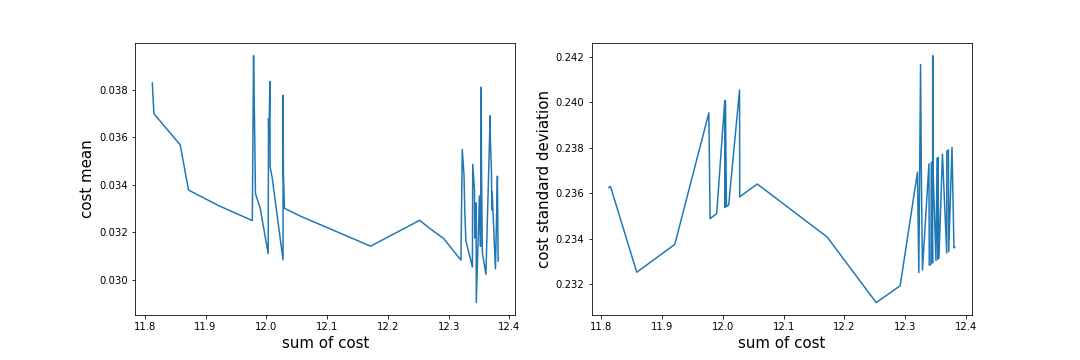

In [318]:
def compute_costs(self, path):
    ang_costs = ConstraintUtils.compute_angle_costs(
        path, self.angle_norm_factor
    )
    # edge_costs = CostUtils.compute_edge_costs(path, self.edge_inst)
    normal_cost = [self.instance[i,j] for (i,j) in path]
    return [normal_cost[i] + ang_costs[i] for i in range(len(normal_cost))]

def var_ksp(self, source, dest, k, thresh = 0.99, cost_thresh=1.05):
    tic = time.time()
    min_node_dists, v_shortest, min_shift_dists = compute_min_node_dists(self)  
    best_paths = [self.best_path]
    tup_path = [np.array(p) for p in self.best_path]
    # sp_set = set(tuple_path)
    sorted_dists = min_node_dists.flatten()[v_shortest]
    _, arr_len  = min_node_dists.shape
    
    # add the best path factors
    path_costs = np.asarray(self.transform_path(self.best_path)[1])
    cost = np.dot(
        path_costs, self.cost_weights
    )
    current_best_mean = np.mean(cost)
    current_best_variance = np.std(cost)
    stds, means, sums = [np.std(cost)], [np.mean(cost)], [np.sum(cost)]
    best_sum = np.sum(cost)
    # iterate and add

    expanded = 0
    for j in range(len(v_shortest)):
        if np.isclose(sorted_dists[j], sorted_dists[j-1]):
            # we always check a path only if it is the x-th appearance
            # print(counter)
            continue
         
        # counter large enough --> expand
        (x2, x3) = v_shortest[j]//arr_len, v_shortest[j]%arr_len
        
        # compute eucledian distances
        x1 = min_shift_dists[x2,x3]
        if self.dists_ba[x1, x2, x3] == 0:
            # print("inc edge to dest")
            # = 0 for inc edges of dest_inds (init of dists_ba)
            continue
        vertices_path = self._combined_paths(
            source, dest, x1, [x2, x3]
        )
        # Compute path costs
        path_costs = np.asarray(self.transform_path(vertices_path)[1])
        cost = np.dot(
            path_costs, self.cost_weights
        ) 
        m, std, s = np.mean(cost), np.std(cost), np.sum(cost)
        if s>cost_thresh*best_sum:
            break
        # update if variance or mean are exceptional
        if std<thresh*current_best_variance or m < thresh * current_best_mean:
            # print(m, std)
            means.append(m)
            stds.append(std)
            sums.append(s)
            current_best_mean = m
            current_best_variance = std
            best_paths.append(vertices_path)
    toc = time.time()
    ksp = [self.transform_path(path) for path in best_paths]
    plot_indicators = (means, stds, sums)
    return plot_indicators, ksp, toc-tic
plot_indicators, var_ksp, tics = var_ksp(graph, start_inds, dest_inds, 5)
means, stds, sums = plot_indicators
# print(np.vstack([means, stds]))
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(sums, stds, label="std")
plt.xlabel("sum of cost", fontsize=15)
plt.ylabel("cost mean", fontsize=15)
plt.subplot(1,2,2)
plt.plot(sums, means, label="mean")
plt.xlabel("sum of cost", fontsize=15)
plt.ylabel("cost standard deviation", fontsize=15)
plt.show()

In [313]:
%matplotlib notebook

<IPython.core.display.Javascript object>


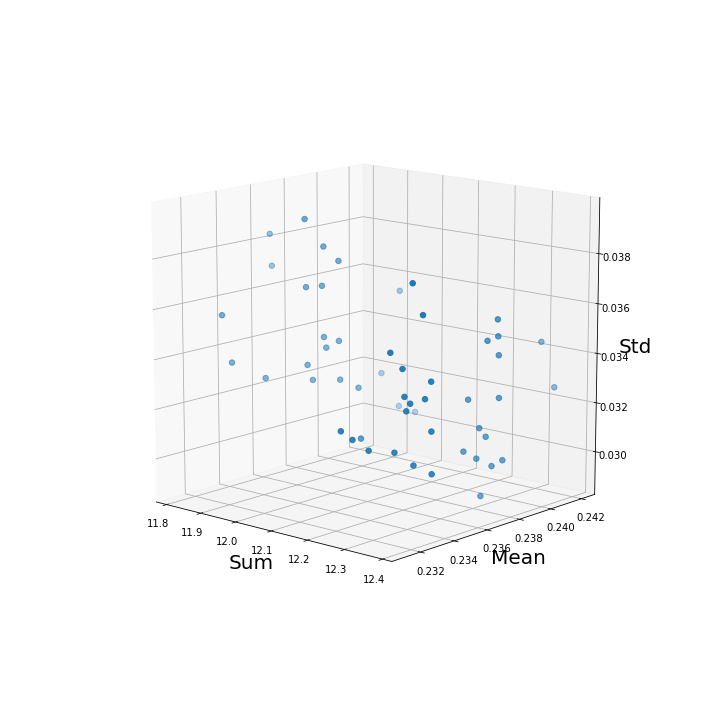

Text(0.5, 0, 'Std')

In [316]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
ax.scatter(sums, means, stds, marker="o", s=30)

ax.set_xlabel('Sum', fontsize=20)
ax.set_ylabel('Mean', fontsize=20)
ax.set_zlabel('Std', fontsize=20)

# plt.show()

<IPython.core.display.Javascript object>


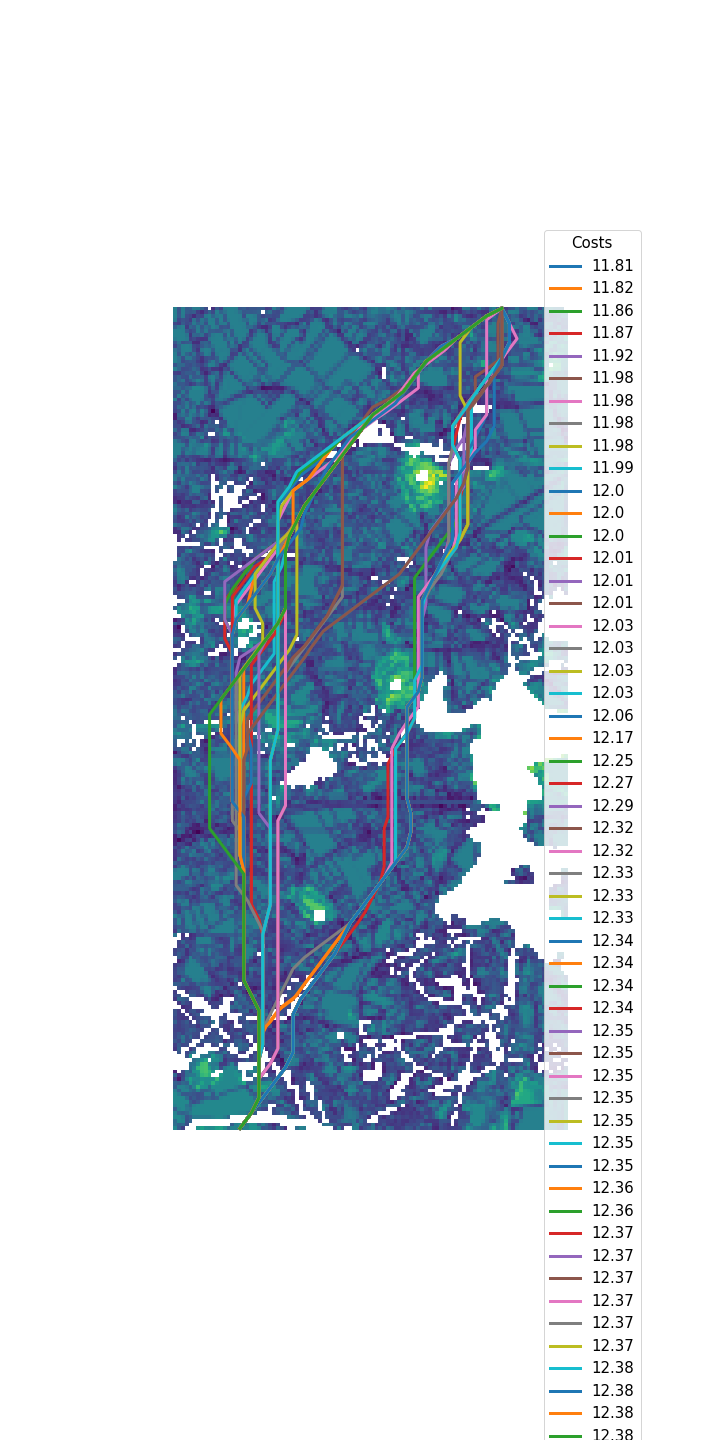

In [332]:
plot_k_sp(var_ksp, graph.instance)

### Investigate Laplace

In [350]:
rad_curr = 20
required_dist = 15
dist_range = 4
sim = 0
while abs(sim- required_dist)>dist_range:
    ksp, toc = laplace(graph, start_inds, dest_inds, 5, radius=rad_curr, cost_add=0.01)
    # print("Sim:", evaluate_sim(ksp, "eucl_max"))
    sim = evaluate_sim(ksp, "eucl_max") 
    # if sim > required_dist:
    rad_curr *= required_dist/sim
    rad_curr = int(rad_curr)
    print(sim, required_dist, rad_curr)
# 

<ipython-input-270-eab3cb11071e>:6: RuntimeWarning: invalid value encountered in subtract
  summed_dists = (self.dists + self.dists_ba - self.instance)


0.1181237192756374
22.394795022030603 15 13
0.1181237192756374
10.939043411222105 15 17
0.1181237192756374
21.410709760557104 15 11
0.1181237192756374
10.939043411222107 15 15
0.1181237192756374
21.410709760557104 15 10
0.1181237192756374
10.939043411222107 15 13
0.1181237192756374
10.939043411222105 15 17
0.1181237192756374
21.410709760557104 15 11
0.1181237192756374
10.939043411222107 15 15
0.1181237192756374
21.410709760557104 15 10
0.1181237192756374
10.939043411222107 15 13
0.1181237192756374
10.939043411222105 15 17
0.1181237192756374
21.410709760557104 15 11
0.1181237192756374
10.939043411222107 15 15
0.1181237192756374
21.410709760557104 15 10
0.1181237192756374
10.939043411222107 15 13
0.1181237192756374
10.939043411222105 15 17
0.1181237192756374
21.410709760557104 15 11
0.1181237192756374
10.939043411222107 15 15
0.1181237192756374
21.410709760557104 15 10
0.1181237192756374
10.939043411222107 15 13
0.1181237192756374
10.939043411222105 15 17
0.1181237192756374
21.4107097605

KeyboardInterrupt: 

## Backup

In [ ]:
out_ksps = collect_ksp_results(most_diverse_jaccard, [1.005, 1.01, 1.015])
res_func = []
for ksp in out_ksps:
    cost, dist = ksp_evaluate(ksp)
    cost_normed = cost - cost_sum * K_PATHS
    res_func.append([cost_normed, - dist])